# DLT

*Direct Linear Transform*

Método sencillo para estimar transformaciones proyectivas mediante la solución de un sistema de ecuaciones lineal.

In [1]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import numpy.linalg      as la
import matplotlib.pyplot as plt

from matplotlib.pyplot   import imshow, subplot, plot

from umucv.htrans import htrans, homog, kgen, null1

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

## matriz fundamental

Algoritmo de los 8 puntos (o más).

Cada correspondencia entre puntos en la imagen izquierda $(x,y,1)$ y derecha $(p,q,1)$, datos conocidos, da lugar a una ecuación sobre los elementos de la matriz F.

$$\begin{bmatrix} x & y& 1\end{bmatrix} \begin{bmatrix} f_1 & f_2 & f_3 \\ f_4 & f_5 & f_6  \\ f_7 & f_8 & f_9 \end{bmatrix} \begin{bmatrix} p \\ q \\1\end{bmatrix} = 0$$

Esto es equivalente a

$$ \begin{bmatrix} px & py &  p & qx & qy & q & x & y & 1\end{bmatrix} \begin{bmatrix} f_1 \\ f_2 \\f_3 \\ f_4 \\ f_5 \\ f_6  \\ f_7 \\ f_8 \\ f_9 \end{bmatrix} = 0$$

Cada fila de la matriz de coeficientes (ecuación homogénea generada por cada correspondencia en el sistema cuya solución es F) se puede obtener como el "outer product" de los puntos correspondientes.

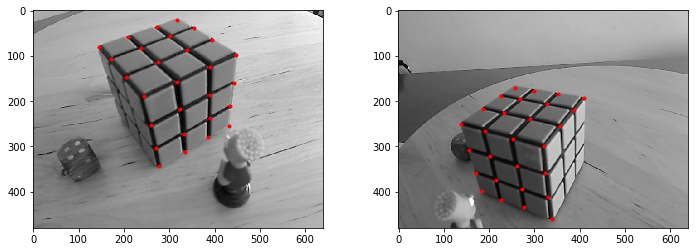

In [2]:
v1 = np.array(
      [[ 278.,  343.],
       [ 335.,  312.],
       [ 386.,  279.],
       [ 433.,  254.],
       [ 270.,  304.],
       [ 332.,  272.],
       [ 389.,  238.],
       [ 434.,  210.],
       [ 260.,  253.],
       [ 324.,  218.],
       [ 389.,  186.],
       [ 442.,  160.],
       [ 244.,  189.],
       [ 317.,  158.],
       [ 390.,  125.],
       [ 447.,   97.],
       [ 204.,  147.],
       [ 276.,  114.],
       [ 340.,   87.],
       [ 395.,   64.],
       [ 172.,  107.],
       [ 238.,   83.],
       [ 302.,   55.],
       [ 355.,   39.],
       [ 146.,   81.],
       [ 210.,   58.],
       [ 273.,   37.],
       [ 318.,   21.]])

v2 = np.array(
      [[ 184.,  399.],
       [ 226.,  418.],
       [ 277.,  434.],
       [ 338.,  460.],
       [ 171.,  358.],
       [ 216.,  374.],
       [ 273.,  394.],
       [ 331.,  412.],
       [ 155.,  307.],
       [ 203.,  321.],
       [ 262.,  342.],
       [ 324.,  358.],
       [ 138.,  251.],
       [ 191.,  265.],
       [ 252.,  284.],
       [ 321.,  299.],
       [ 186.,  218.],
       [ 233.,  227.],
       [ 291.,  240.],
       [ 357.,  255.],
       [ 226.,  188.],
       [ 269.,  196.],
       [ 327.,  206.],
       [ 387.,  220.],
       [ 257.,  170.],
       [ 299.,  177.],
       [ 352.,  185.],
       [ 409.,  194.]])

x1 = rgb2gray(readrgb('cube3.png'))
x2 = rgb2gray(readrgb('cube4.png'))

fig(12,4)
subplot(1,2,1)
imshow(x1,'gray'); ax = plt.axis()
plot(v1[:,0],v1[:,1],'r.'); plt.axis(ax)
subplot(1,2,2)
imshow(x2,'gray')
plot(v2[:,0],v2[:,1],'r.'); plt.axis(ax);

Cuando no hay outliers la matriz $F$ se puede obtener resolviendo un sencillo sistema de ecuaciones. En la práctica es mejor usar la siguiente función de OpenCV que admite correspondencias incorrectas.

In [3]:
F,_ = cv.findFundamentalMat(v1,v2,cv.FM_LMEDS)
F

array([[  1.19789663e-06,   6.12855256e-06,   8.51137650e-04],
       [  1.04276245e-05,   2.57755811e-06,  -1.37042447e-02],
       [  1.02107838e-03,   5.88401371e-03,   1.00000000e+00]])

Comprobemos que funciona:

In [4]:
[ x2 @ F @ x1 for x1,x2 in zip(homog(v1),homog(v2)) ]

[-0.051837945445248224,
 -0.038979293405927429,
 -0.015402972955562255,
 -5.6843418860808015e-14,
 -0.03379516631283952,
 0.0008633756838634099,
 -0.0042043851678297273,
 -5.6843418860808015e-14,
 -3.1086244689504383e-14,
 0.0021508341764109318,
 -0.00024978149889598456,
 0.049328513422774556,
 -2.708944180085382e-14,
 0.025669930373434013,
 0.013449176247676942,
 0.033964949074825945,
 0.0033938903417631838,
 -0.00011874031539349517,
 -0.0038717892251498576,
 -0.0094886205563153858,
 0.0049771822500848106,
 0.016197341504458729,
 -0.0063197525869047588,
 -3.9968028886505635e-14,
 -0.018464490469187966,
 -0.019908589885858419,
 -2.7977620220553945e-14,
 -3.5305092183079978e-14]

In [5]:
sum([ abs(x2 @ F @ x1) for x1,x2 in zip(homog(v1),homog(v2)) ])

0.35263672090068066

No son ceros perfectos, pero el residuo es razonablemente pequeño, puede no estar mal del todo.

Vamos a calcular nosotros mismos la matriz fundamental resolviendo un sistema de ecuaciones homogéneo. Para que el sistema esté bien condicionado numéricamente es necesario trabajar con coordenadas del orden de 1, en vez de coordenadas de pixels, que al estar multiplicadas entre sí producen elementos de magnitudes muy descompensadas. Por tanto, vamos a normalizar los pixels, quitando la transformación de calibración, de modo que obtendremos inicialmente una aproximación a la matriz Esencial.

In [6]:
K = kgen((640,480),1.6)

hn1 = homog(v1) @ la.inv(K).T
hn2 = homog(v2) @ la.inv(K).T

Formamos la matriz de coefientes del sistema homogéneo y lo resolvemos con `null1` (en su momento vimos (en el notebook de [sistemas de ecuaciones](sistecs.ipynb)) que es un sencillo algoritmo basado en la descomposición en valores singulares).

In [7]:
dat = np.array([np.outer(x,y) for x,y in zip(hn2,hn1) ])
myE = null1(dat.reshape(-1,9)).reshape(3,3)

In [8]:
myE

array([[-0.05403926, -0.2449397 , -0.19734796],
       [-0.28140061, -0.13550397,  0.62853407],
       [-0.24705399, -0.56329427, -0.16492203]])

In [9]:
[ x2 @ myE @ x1 for x1,x2 in zip(hn1,hn2) ]

[0.00024934208994203955,
 0.00049612646605642907,
 -0.00044988144236908501,
 -0.00064797540669055131,
 0.00088546621823229477,
 -0.0019085600249310608,
 0.00048447386333586029,
 0.0016523540420583377,
 -0.00059626712497805323,
 0.00014978661741415003,
 0.0019557803104391161,
 -0.0028354587380717694,
 0.0011773168417393148,
 -0.0016701622144319611,
 0.0010309105809614832,
 -0.0004082329794874856,
 -0.00063488178438944609,
 1.4829459719811755e-05,
 0.00090726277807529065,
 0.0023430019758732823,
 -0.0011727728089377665,
 -0.002770252633175152,
 0.00018849906816439943,
 -0.00027720191887117829,
 0.0018704253412958893,
 0.0017314058647010522,
 -0.0009248675357606817,
 -0.00084869983287316764]

Se cumple bastante bien la restricción en todas las correspondencias. Es muy simple ahora conseguir la matriz fundamental, que opera directamente con coordenadas de pixel:

In [10]:
myF = la.inv(K).T @ myE @ la.inv(K)

In [11]:
[ x2 @ myF @ x1 for x1,x2 in zip(homog(v1),homog(v2)) ]

[0.00024934208994187301,
 0.00049612646605634581,
 -0.00044988144236923766,
 -0.00064797540669048193,
 0.00088546621823232252,
 -0.0019085600249310608,
 0.00048447386333583253,
 0.0016523540420584348,
 -0.00059626712497812262,
 0.00014978661741410493,
 0.0019557803104390814,
 -0.0028354587380717278,
 0.0011773168417392732,
 -0.0016701622144319472,
 0.0010309105809614416,
 -0.00040823297948755499,
 -0.00063488178438947385,
 1.4829459719783999e-05,
 0.00090726277807529065,
 0.0023430019758732823,
 -0.001172772808937822,
 -0.002770252633175152,
 0.00018849906816437167,
 -0.00027720191887115053,
 0.0018704253412958338,
 0.0017314058647009967,
 -0.00092486753576073721,
 -0.00084869983287316764]

Las condiciones se cumplen también muy bien sobre pixels crudos. Y los valores numéricos de nuestra matriz Fundamental son muy parecidos a los conseguidos por OpenCV. (Para comparar las matrices, que son homogéneas, es necesario ponerlas con una escala común, p.ej., dividiendo todo por el mayor elemento):

In [12]:
myF = myF/myF[2,2] 
myF

array([[  1.67819836e-06,   7.60664384e-06,   7.75263202e-04],
       [  8.73894349e-06,   4.20809871e-06,  -1.38002525e-02],
       [  1.29384944e-03,   5.51244815e-03,   1.00000000e+00]])

In [13]:
F

array([[  1.19789663e-06,   6.12855256e-06,   8.51137650e-04],
       [  1.04276245e-05,   2.57755811e-06,  -1.37042447e-02],
       [  1.02107838e-03,   5.88401371e-03,   1.00000000e+00]])

Incluso conseguimos un residuo menor (!?):

In [14]:
sum([ abs(x2 @ myF @ x1) for x1,x2 in zip(homog(v1),homog(v2)) ])

0.24652512701222662

Esto no significa que este método tan simple sea mejor que el de OpenCV. Lo que ocurre es que no hemos impuesto a nuestra $F$ una condición importante: que todas las líneas epipolares generadas pasen por un punto común: el "epipolo", que es la imagen del centro de la otra cámara. Matemáticamente esto significa que $F$ tiene que tener rango 2, o sea, su tercer valor singular nulo.

In [15]:
la.svd(F)[1]

array([  1.00011209e+00,   8.67211126e-05,   2.87391801e-15])

In [16]:
la.svd(myF)[1]

array([  1.00011154e+00,   8.46295499e-05,   4.06910205e-07])

En nuestro caso $s_3$ es $\sim 100$ veces menor que el $s_2$, que no está mal, pero no es un cero numérico.

## homografía

Dado un conjunto de correspondencias  $(x,y,1) \leftrightarrow (p,q,1)$ relacionadas por una homografía, cada una da lugar a una ecuación

$$\begin{bmatrix} x \\ y \\1\end{bmatrix} = \lambda \begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6  \\ h_7 & h_8 & h_9 \end{bmatrix}  \begin{bmatrix} p \\ q \\1\end{bmatrix}$$

Se desconoce la escala homogénea $\lambda$ de cada ecuación. Pero es posible transformarlo a 3 ecuaciones homogéneas. Como ambos lados de la ecuación son vectores proporcionales, su producto vectorial (cross) debe ser cero.

$$ \begin{bmatrix} x \\ y \\1\end{bmatrix} \times \begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6  \\ h_7 & h_8 & h_9 \end{bmatrix}  \begin{bmatrix} p \\ q \\1\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\0\end{bmatrix} $$

Desarrollando esto podemos construir 3 ecuaciones homogéneas (2 de ellas independientes) para los elementos de la homografía.

$$\begin{bmatrix} 0 & 0 & 0 & p & q & 1 & -p y & -q y & -y \\ 
            -p & -q & -1& 0& 0& 0& p x& q x& x\\
            p y& q y& y& -p x& -q x& -x& 0& 0 & 0 \end{bmatrix} \begin{bmatrix} h_1 \\ h_2 \\h_3 \\ h_4 \\ h_5 \\ h_6  \\ h_7 \\ h_8 \\ h_9 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\0\end{bmatrix} $$



In [17]:
X = np.array(
   [[0,   0  ],
    [0,   1  ],
    [0.5, 1  ],
    [0.5, 0.5],
    [1,   0.5],
    [1,   0  ]])

Y = np.array(
   [[ 260.,  320.],
    [ 192.,  272.],
    [ 267.,  260.],
    [ 304.,  278.],
    [ 374.,  266.],
    [ 425.,  285.]])

Estos datos de prueba los hemos creado con una transformación conocida.

In [18]:
H = np.array([[250,-11, 260],
              [22,  33, 320],
              [0.2,  0.3, 1]])

np.round(htrans(H,X))

array([[ 260.,  320.],
       [ 192.,  272.],
       [ 267.,  260.],
       [ 304.,  278.],
       [ 374.,  266.],
       [ 425.,  285.]])

In [19]:
def eqs(x,y):
    x_0, x_1 = x
    y_0, y_1 = y
    return [[0, 0, 0, x_0, x_1, 1, -x_0*y_1, -x_1*y_1, -y_1], 
            [-x_0, -x_1, -1, 0, 0, 0, x_0*y_0, x_1*y_0, y_0],
            [x_0*y_1, x_1*y_1, y_1, -x_0*y_0, -x_1*y_0, -y_0, 0, 0, 0]]

In [20]:
eqs(X[0],Y[0])

[[0, 0, 0, 0.0, 0.0, 1, -0.0, -0.0, -320.0],
 [-0.0, -0.0, -1, 0, 0, 0, 0.0, 0.0, 260.0],
 [0.0, 0.0, 320.0, -0.0, -0.0, -260.0, 0, 0, 0]]

In [21]:
A = sum([eqs(x,y) for x,y in zip(X,Y)],[])

In [22]:
myH = null1(A).reshape(3,3)
myH

array([[ -5.24066159e-01,   1.86314113e-02,  -5.33991927e-01],
       [ -5.23317066e-02,  -7.32377090e-02,  -6.57079124e-01],
       [ -4.35798055e-04,  -6.35173304e-04,  -2.05307351e-03]])

In [23]:
myH = myH/myH[2,2]
myH

array([[  2.55259325e+02,  -9.07488756e+00,   2.60093915e+02],
       [  2.54894461e+01,   3.56722292e+01,   3.20046564e+02],
       [  2.12266172e-01,   3.09376796e-01,   1.00000000e+00]])

In [24]:
htrans(myH,X)

array([[ 260.09391462,  320.04656447],
       [ 191.70877926,  271.67030523],
       [ 267.49985605,  260.30444689],
       [ 303.91783315,  278.09440645],
       [ 373.68893389,  265.82604374],
       [ 425.11558233,  285.03312113]])

In [25]:
Y

array([[ 260.,  320.],
       [ 192.,  272.],
       [ 267.,  260.],
       [ 304.,  278.],
       [ 374.,  266.],
       [ 425.,  285.]])

## camera resection

pendiente

## triangulation

pendiente